# User Clustering using Embeddings [WIP]

**Date:** 

**Dataset:** German Web Tracking

In [1]:
import sys
import os

sys.path.append(os.path.abspath("../"))

In [39]:
import pickle
import umap
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

from cybergpt.models.utils import (
    feature_df_to_numpy,
    fit_dirichlet,
    dirichlet_js_matrix,
)

## Data

In order to generate the required processed data, please run the following:

**Embeddings**

```shell
python -m cybergpt.models.embed.websites \
    --data_csv path/to/raw/data.csv \
    --output_dir data/embeddings \
    --models openai openai-large minilm e5 tfidf \
    --sample_size 200
```

Note that sequences of domain visits are first mapped to strings which look like this:

`"Monday 14:15, Visits: google.com (10s) -> youtube.com (89s) -> google.com (32s) -> amazon.de (123s)"`

**Features**

```shell
python -m cybergpt.models.features \
    --data_csv path/to/raw/data.csv \
    --output_dir data/features
```

In [3]:
SEQUENCES_PICKLE = "../data/embeddings/preprocessed_dataset.pkl"
EMBEDDINGS_PICKLES = {
    "openai": "../data/embeddings/embeddings_openai.pkl",
    # "openai-large": "../data/embeddings/embeddings_openai-large.pkl",
    # "tfidf": "../data/embeddings/embeddings_tfidf.pkl",
    # "e5": "../data/embeddings/embeddings_e5.pkl",
    "minilm": "../data/embeddings/embeddings_minilm.pkl",
}
FEATURES_PICKLE = "../data/features/features.pkl"

In [4]:
data = pickle.load(open(SEQUENCES_PICKLE, "rb"))
sequences = data["string_sequences"]
labels = data["labels"]

embeddings = {e: pickle.load(open(p, "rb")) for e, p in EMBEDDINGS_PICKLES.items()}

In [5]:
feature_data = pickle.load(open(FEATURES_PICKLE, "rb"))
all_labels = feature_data["labels"]
features = feature_data["features"]
np_features = feature_df_to_numpy(features)

In [6]:
# Align features with embeddings subset
users = pd.Series(labels).drop_duplicates().to_list()
features["label"] = all_labels
features = pd.concat([features[features["label"] == u] for u in users])
feature_arrays = [
    np.array([f for f, l in zip(np_features, all_labels) if l == u]) for u in users
]
np_features = np.concatenate(feature_arrays)

In [7]:
print("Shapes:")
{"features": np_features.shape} | {k: v.shape for k, v in embeddings.items()}

Shapes:


{'features': (7806, 51), 'openai': (7806, 1536), 'minilm': (7806, 384)}

In [8]:
features.shape

(7806, 50)

In [9]:
print(f"Number of sequences: {len(labels)}")

Number of sequences: 7806


In [78]:
proj_dim = 2

reducer = umap.UMAP(
    n_components=proj_dim,
    random_state=42,
    n_neighbors=10,
    min_dist=0.5,
)

embeddings_reduced = reducer.fit_transform(embeddings["openai"])

/opt/homebrew/anaconda3/envs/cybergpt-datasets/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


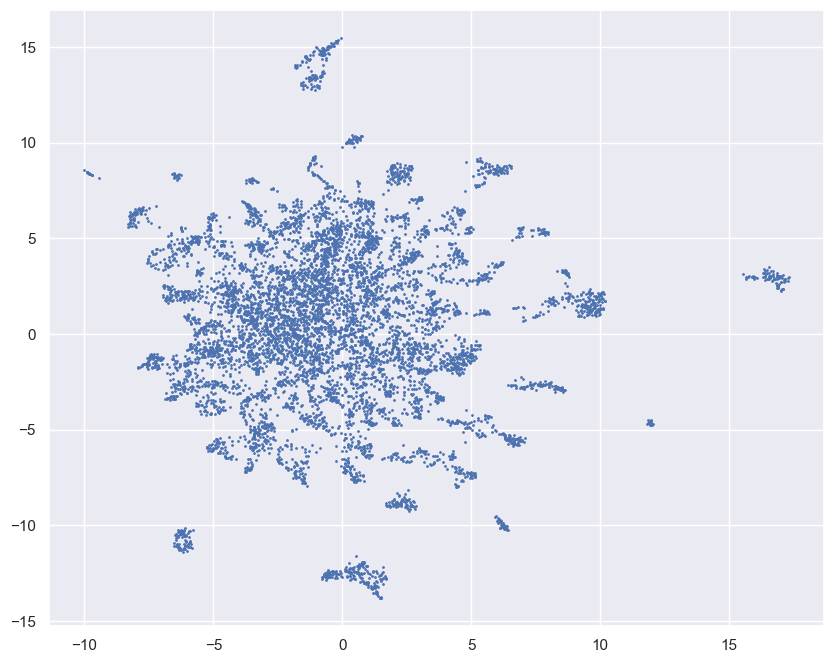

In [79]:
sns.set()
plt.figure(figsize=[10, 8])
plt.scatter(*embeddings_reduced.T, s=1)
plt.show()

In [80]:
n_components = 25

gmm = GaussianMixture(
    n_components=n_components,
    random_state=42,
    verbose=1,
)
gmm.fit(embeddings_reduced)

Initialization 0
Initialization converged: True


GaussianMixture(n_components=25, random_state=42, verbose=1)

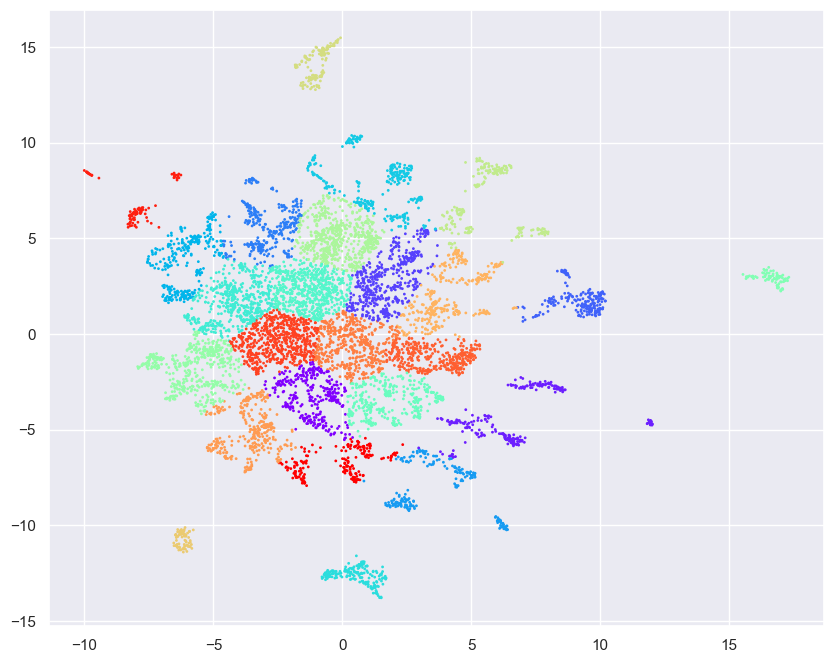

In [81]:
top_components = gmm.predict(embeddings_reduced)
plt.figure(figsize=[10, 8])
plt.scatter(*embeddings_reduced.T, s=1, c=list(top_components), cmap="rainbow")
plt.show()

In [82]:
probs = gmm.predict_proba(embeddings_reduced)

In [113]:
unique_labels = np.unique(labels)
label_dirichlet_params = np.zeros((len(unique_labels), n_components))

print(f"Fitting Dirichlet distributions for {len(unique_labels)} classes...")
for i, label in enumerate(tqdm(unique_labels, desc="Processing classes")):
    label_mask = labels == label
    label_probs = probs[label_mask]
    label_dirichlet_params[i] = fit_dirichlet(label_probs)

Fitting Dirichlet distributions for 200 classes...


Processing classes:   0%|          | 0/200 [00:00<?, ?it/s]

/Users/marcos/Documents/projects/bai/cybergpt-datasets/cybergpt/models/utils.py:37: RuntimeWarning: divide by zero encountered in log
  digamma(np.sum(alpha)) - digamma(alpha) + np.mean(np.log(vectors), axis=0)


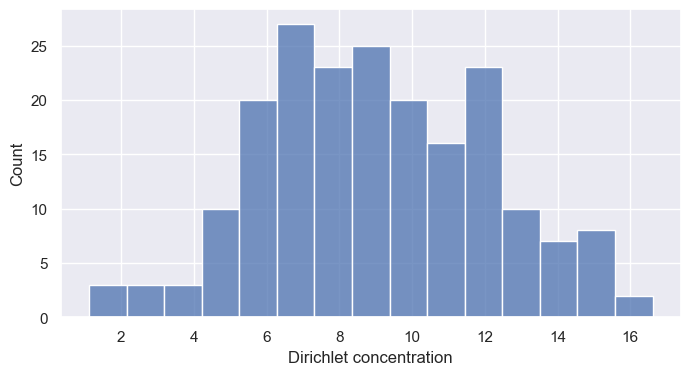

In [114]:
plt.figure(figsize=[8, 4])
sns.histplot(label_dirichlet_params.sum(axis=1), bins=15)
plt.xlabel("Dirichlet concentration")
plt.show()

In [115]:
label_dirichlet_params.shape

(200, 25)

In [140]:
reducer = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=3,
    min_dist=0.02,
)

p_reduced = reducer.fit_transform(label_dirichlet_params)

/opt/homebrew/anaconda3/envs/cybergpt-datasets/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


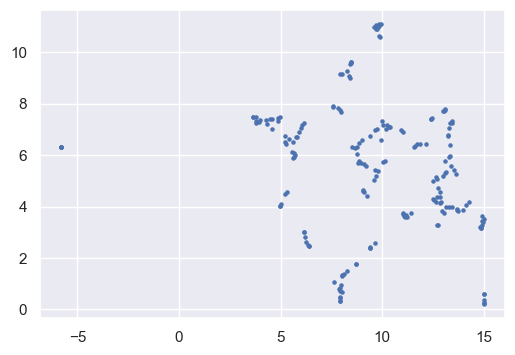

In [141]:
sns.set()
plt.figure(figsize=[6, 4])
plt.scatter(*p_reduced.T, s=5)
plt.show()

In [149]:
n_components = 5

gmm = GaussianMixture(
    n_components=n_components,
    random_state=42,
    verbose=1,
)
gmm.fit(p_reduced)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=5, random_state=42, verbose=1)

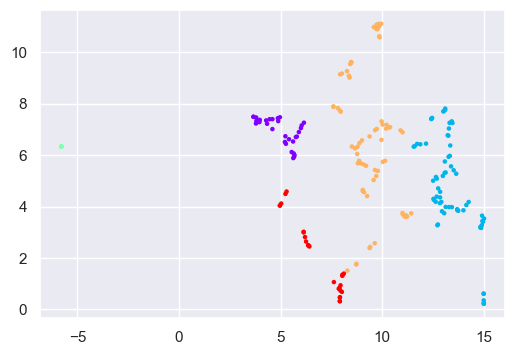

In [150]:
clusters = gmm.predict(p_reduced)
plt.figure(figsize=[6, 4])
plt.scatter(*p_reduced.T, s=5, c=list(clusters), cmap="rainbow")
plt.show()

In [151]:
df_clusters = pd.DataFrame({"cluster": clusters, "user": users})

In [152]:
df_clusters["cluster"].value_counts()

cluster
3    72
1    68
0    31
4    25
2     4
Name: count, dtype: int64

In [153]:
mean_feature = features.drop("session_time_category", axis=1).groupby("label").mean()

In [154]:
mean_feature["cluster"] = [
    df_clusters[df_clusters["user"] == i]
    .rename(columns={"label": "cluster"})
    .iloc[0]["cluster"]
    for i in mean_feature.index
]

In [155]:
mean_feature.corr()["cluster"].abs().sort_values()

unique_domains              0.009269
domain_entropy              0.009534
has_search                  0.013922
domain_switch_rate          0.014408
has_news                    0.019883
rapid_transitions           0.020188
domain_diversity_ratio      0.022763
domain_return_rate          0.022763
session_start_hour          0.025121
std_time_between_visits     0.027293
unique_tlds                 0.028058
spans_multiple_days         0.032066
long_views                  0.033430
total_active_time           0.034153
max_page_duration           0.041528
has_social_media            0.045557
has_commerce                0.046694
has_email                   0.046798
std_page_duration           0.048276
is_weekend                  0.049052
avg_subdomain_depth         0.051016
num_visits                  0.056710
rapid_sequence_changes      0.061220
session_end_hour            0.067461
most_common_tld_freq        0.069196
avg_dwell_time              0.076062
most_common_domain_freq     0.077566
m

In [157]:
users_0 = df_clusters[df_clusters["cluster"] == 0]["user"].to_list()
users_1 = df_clusters[df_clusters["cluster"] == 1]["user"].to_list()
users_2 = df_clusters[df_clusters["cluster"] == 2]["user"].to_list()

In [166]:
from random import sample

sample([s for s, l in zip(sequences, labels) if l in users_1], 30)

['Sunday 13:22, Visits: web.de (394s) -> web.de (222s) -> web.de (138s) -> internationalcupid.com (11s)',
 'Friday 16:37, Visits: myhermes.de (19s) -> kik.de (4s) -> kik.de (252s) -> web.de (222s) -> apotal.de (2s) -> web.de (688s) -> apotal.de (2s) -> myhermes.de (186s) -> apotal.de (14s) -> indeed.es (2s) -> web.de (132s) -> aponeo.de (213s) -> aponeo.de (40s) -> web.de (22s) -> emarsys.net (2s) -> apotal.de (4s) -> web.de (84s) -> myhermes.de (286s) -> medpets.de (2s) -> web.de (46s) -> myhermes.de (8s) -> zooplus.de (24s) -> zooroyal.de (8s) -> web.de (26s) -> myhermes.de (4s) -> bibbis-heimtierkost.de (210s) -> zooroyal.de (199s) -> zooroyal.de (35s) -> zooplus.de (80s) -> zooroyal.de (156s) -> myhermes.de (12s) -> bibbis-heimtierkost.de (36s) -> web.de (2s) -> zooroyal.de (338s) -> ebay-kleinanzeigen.de (86s) -> medpets.de (54s) -> myhermes.de (6s) -> zooplus.de (64s) -> bitiba.de (60s) -> medpets.de (1s) -> bitiba.de (2s) -> medpets.de (2s) -> bitiba.de (2s) -> medpets.de (364s)

In [159]:
[s for s, l in zip(sequences, labels) if l in users_1]

['Monday 9:31, Visits: postbank.de (58s) -> postbank.de (24s) -> eschenbach-optik.com (1s) -> postbank.de (2s) -> eschenbach-optik.com (1s) -> postbank.de (2s) -> eschenbach-optik.com (292s) -> schweizer-optik.de (246s) -> schweizer-optik.de (17s) -> eschenbach-optik.com (908s) -> facebook.com (242s) -> google.de (179s) -> facebook.com (285s) -> schweizer-optik.de (396s) -> postbank.de (978s) -> facebook.com (218s) -> facebook.com (6s) -> whatsapp.com (332s) -> eschenbach-optik.com (392s) -> schweizer-optik.de (30s) -> schweizer-optik.de (8s) -> whatsapp.com (250s) -> facebook.com (158s) -> facebook.com (156s) -> facebook.com (4s) -> whatsapp.com (28s) -> schweizer-optik.de (16s) -> schweizer-optik.de (2s) -> schweizer-optik.de (2s) -> whatsapp.com (331s) -> facebook.com (2s) -> lieferando.de (6s) -> google.de (30s) -> lieferando.de (8s) -> schweizer-optik.de (2s) -> google.de (273s) -> epizzashop.de (8s) -> schweizer-optik.de (2s) -> whatsapp.com (2s) -> whatsapp.com (2s) -> whatsapp.

In [160]:
[s for s, l in zip(sequences, labels) if l in users_2]

['Monday 9:12, Visits: ebay.de (104s) -> ebay.de (36s) -> amazon.com (36s) -> ebay.de (24s) -> amazon.com (14s) -> gls-group.eu (8s) -> amazon.com (26s) -> gls-group.eu (21s) -> amazon.com (108s) -> ebay.de (38s) -> gls-group.eu (12s) -> ebay.de (40s) -> gls-group.eu (132s) -> ebay.de (6s) -> gls-group.eu (6s) -> ebay.de (28s) -> gls-group.eu (12s) -> amazon.com (44s) -> ebay.de (167s) -> amazon.com (139s) -> zoobedarf24.de (67s) -> paypal.com (41s) -> zoobedarf24.de (84s) -> ebay.de (221s) -> amazon.com (304s) -> zoobedarf24.de (10s) -> paypal.com (20s) -> amazon.com (4s) -> paypal.com (14s) -> amazon.com (4s) -> paypal.com (18s) -> zoobedarf24.de (2s) -> amazon.com (22s) -> gls-group.eu (2s) -> zoobedarf24.de (1110s) -> amazon.com (346s) -> amazon.com (18s) -> gls-group.eu (12s) -> amazon.com (8s) -> gls-group.eu (2s) -> amazon.com (6s) -> gls-group.eu (16s) -> amazon.com (30s) -> gls-group.eu (59s) -> amazon.com (10s) -> ebay.de (26s) -> gls-group.eu (176s) -> ebay.de (2s) -> gls-gr